In [1]:
import pandas as pd
import numpy as np
from collections import Counter

# dataset is accessible at https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt (https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Books_v1_02.tsv.gz)
df = pd.read_csv('amazon_reviews_us_Digital_Software_v1_00.tsv', sep='\t', header=None, on_bad_lines='skip')

print(df.head())

            0            1               2           3               4    
0  marketplace  customer_id       review_id  product_id  product_parent  \
1           US     17747349  R2EI7QLPK4LF7U  B00U7LCE6A       106182406   
2           US     10956619  R1W5OMFK1Q3I3O  B00HRJMOM4       162269768   
3           US     13132245   RPZWSYWRP92GI  B00P31G9PQ       831433899   
4           US     35717248  R2WQWM04XHD9US  B00FGDEPDY       991059534   

                                           5                 6            7    
0                               product_title  product_category  star_rating  \
1                    CCleaner Free [Download]  Digital_Software            4   
2          ResumeMaker Professional Deluxe 18  Digital_Software            3   
3                   Amazon Drive Desktop [PC]  Digital_Software            1   
4  Norton Internet Security 1 User 3 Licenses  Digital_Software            5   

              8            9     10                 11              

C:\Users\Frederico\AppData\Local\Temp\ipykernel_308\643836554.py:6: DtypeWarning: Columns (1,4,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('amazon_reviews_us_Digital_Software_v1_00.tsv', sep='\t', header=None, on_bad_lines='skip')


In [2]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101837 entries, 0 to 101836
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       101837 non-null  object
 1   1       101837 non-null  object
 2   2       101837 non-null  object
 3   3       101837 non-null  object
 4   4       101837 non-null  object
 5   5       101837 non-null  object
 6   6       101837 non-null  object
 7   7       101837 non-null  object
 8   8       101837 non-null  object
 9   9       101837 non-null  object
 10  10      101837 non-null  object
 11  11      101837 non-null  object
 12  12      101837 non-null  object
 13  13      101832 non-null  object
 14  14      101832 non-null  object
dtypes: object(15)
memory usage: 11.7+ MB


In [3]:
df.columns = ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 
            'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date']

print(df.head())

   marketplace  customer_id       review_id  product_id  product_parent   
0  marketplace  customer_id       review_id  product_id  product_parent  \
1           US     17747349  R2EI7QLPK4LF7U  B00U7LCE6A       106182406   
2           US     10956619  R1W5OMFK1Q3I3O  B00HRJMOM4       162269768   
3           US     13132245   RPZWSYWRP92GI  B00P31G9PQ       831433899   
4           US     35717248  R2WQWM04XHD9US  B00FGDEPDY       991059534   

                                product_title  product_category  star_rating   
0                               product_title  product_category  star_rating  \
1                    CCleaner Free [Download]  Digital_Software            4   
2          ResumeMaker Professional Deluxe 18  Digital_Software            3   
3                   Amazon Drive Desktop [PC]  Digital_Software            1   
4  Norton Internet Security 1 User 3 Licenses  Digital_Software            5   

   helpful_votes  total_votes  vine  verified_purchase     review_he

In [4]:
print(df['review_body'][1:10])
print(df['star_rating'][1:10])  

1                                       So far so good
2                        Needs a little more work.....
3                                       Please cancel.
4                                   Works as Expected!
5    I've had Webroot for a few years. It expired a...
6    EXCELLENT software !!!!!  Don't need to do any...
7    The variations created by Win10 induced this p...
8    Horrible!  Would not upgrade previous version ...
9                                      Waste of time .
Name: review_body, dtype: object
1    4
2    3
3    1
4    5
5    4
6    5
7    1
8    1
9    1
Name: star_rating, dtype: object


## Sentiment analysis

In [5]:
all_reviews = df['review_body'][1:]
all_ratings = df['star_rating'][1:]

In [6]:
all_reviews = all_reviews[:1000]
all_ratings = all_ratings[:1000]
all_ratings = all_ratings.astype('int') - 1

In [7]:
print(all_ratings[1:10])

2     2
3     0
4     4
5     3
6     4
7     0
8     0
9     0
10    4
Name: star_rating, dtype: int32


In [8]:
reviews = list()

for review in all_reviews:
    reviews.append(review)

print(reviews[:10])

['So far so good', 'Needs a little more work.....', 'Please cancel.', 'Works as Expected!', "I've had Webroot for a few years. It expired and I decided to purchase a renewal on Amazon. I went through hell trying to uninstall the expired version in order to install the new.  I called Webroot and had their representative remote into my computer at his request. He was clueless as a bad joke and consumed 29 minutes and 57 seconds of my time forever.  He initially told me it wasn't compatible with Windows 10, but I finally managed to convince him that it is indeed compatible with Windows 10 as it was working on my computer before it expired and also I showed him a review on Amazon to convince him that it works on Windows 10. Finally, he offered to connect me with a senior consultant for over 100 dollars. I declined and told him I'd fix the issue myself. This guy was less helpful than a severed limb.  After spending some time on Google, the issue is now fixed. Webroot should just get rid of 

In [9]:
#from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

sample_text = "originally gave this a 2 star but I think it only deserves 1. I simply can't wrap my head around the following. picture this, you add a task to your list. the reminder feature is on.you want to change the time on the reminder feature so you click it."
               
tokens = tokenizer.tokenize(sample_text)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(f'{sample_text}')
print('='*60)
print(tokens)
print('='*60)
print(ids)

originally gave this a 2 star but I think it only deserves 1. I simply can't wrap my head around the following. picture this, you add a task to your list. the reminder feature is on.you want to change the time on the reminder feature so you click it.
['originally', 'gave', 'this', 'a', '2', 'star', 'but', 'I', 'think', 'it', 'only', 'deserves', '1', '.', 'I', 'simply', 'can', "'", 't', 'wrap', 'my', 'head', 'around', 'the', 'following', '.', 'picture', 'this', ',', 'you', 'add', 'a', 'task', 'to', 'your', 'list', '.', 'the', 'reminder', 'feature', 'is', 'on', '.', 'you', 'want', 'to', 'change', 'the', 'time', 'on', 'the', 'reminder', 'feature', 'so', 'you', 'click', 'it', '.']
[2034, 1522, 1142, 170, 123, 2851, 1133, 146, 1341, 1122, 1178, 18641, 122, 119, 146, 2566, 1169, 112, 189, 10561, 1139, 1246, 1213, 1103, 1378, 119, 3439, 1142, 117, 1128, 5194, 170, 4579, 1106, 1240, 2190, 119, 1103, 15656, 2672, 1110, 1113, 119, 1128, 1328, 1106, 1849, 1103, 1159, 1113, 1103, 15656, 2672, 1177

In [10]:
encoding = tokenizer.encode_plus(
      sample_text,
      add_special_tokens=True,
      max_length=128,
      truncation=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

c:\Users\Frederico\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [11]:
from sklearn.model_selection import train_test_split


X_train, X_rem, y_train, y_rem = train_test_split(reviews, all_ratings, train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [12]:
import torch 
from torch.utils.data import Dataset

class AmazonReview(Dataset):
    def __init__(self, review, target, tokenizer, max_len):
        self.review = review
        self.target = target 
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.review)
    
    def __getitem__(self,index):
        review = self.review[index]
        encoding = self.tokenizer.encode_plus(
                          review,
                          add_special_tokens=True,
                          max_length=128,
                          truncation=True,
                          return_token_type_ids=False,
                          pad_to_max_length=True,
                          return_attention_mask=True,
                          return_tensors='pt')
        
        return {'review' : review,
                'input_id': encoding['input_ids'].flatten(),
                'attention_mask':encoding['attention_mask'].flatten(),
                'target': torch.tensor(int(self.target[index]))
               }

In [13]:
tokenizer = transformers.BertTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 128

training_data = AmazonReview(review = np.array(X_train),
                               target = np.array(y_train),
                               tokenizer = tokenizer,
                               max_len = MAX_LEN)

validation_data = AmazonReview(review = np.array(X_valid),
                               target = np.array(y_valid),
                               tokenizer = tokenizer,
                               max_len = MAX_LEN)

test_data = AmazonReview(review = np.array(X_test),
                               target = np.array(y_test),
                               tokenizer = tokenizer,
                               max_len = MAX_LEN)

In [14]:
print(len(training_data),len(test_data),len(validation_data))

800 100 100


In [15]:
from torch.utils.data import DataLoader
## DataLoader
BATCH_SIZE = 16
train_loader = DataLoader(training_data , batch_size = BATCH_SIZE , shuffle = True)
test_loader = DataLoader(test_data , batch_size = BATCH_SIZE , shuffle = False)
val_loader = DataLoader(validation_data , batch_size = BATCH_SIZE , shuffle = False)

In [16]:
sample_batch = iter(train_loader)
sample_batch = next(sample_batch)
sample_batch.keys()
print(sample_batch['target'].shape, sample_batch['input_id'].shape, sample_batch['attention_mask'].shape)

torch.Size([16]) torch.Size([16, 128]) torch.Size([16, 128])


c:\Users\Frederico\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [17]:
from transformers import BertModel

bert_model = BertModel.from_pretrained(MODEL_NAME)


## testing the output of bert model
x = bert_model(sample_batch['input_id'].view(BATCH_SIZE,MAX_LEN)
               ,sample_batch['attention_mask'].view(BATCH_SIZE,MAX_LEN))

print('Last hidden layer size for input as batch',x[0].shape)
print('Pooled output size for input as batch',x[1].shape)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Last hidden layer size for input as batch torch.Size([16, 128, 768])
Pooled output size for input as batch torch.Size([16, 768])


In [18]:
from torch import nn

class SentimentClassifier(nn.Module):
    def __init__(self,num_classes):
        super(SentimentClassifier,self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(p = 0.3)
        self.linear = nn.Linear(self.bert.config.hidden_size,num_classes)
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self,input_ids , attention_mask):
        temp = self.bert(input_ids,attention_mask) # Here we have added one linear layer on top of 
        pooled_output = temp[1]                    # BERT-base with number of output = 3 
        out = self.dropout(pooled_output)          # 
        out = self.linear(out)
        return out

In [19]:
num_classes = 5
model = SentimentClassifier(num_classes)

sample_linear_output = model(sample_batch['input_id']
                             ,sample_batch['attention_mask'])

s = nn.Softmax(dim=1)
final_out = s(sample_linear_output)
final_out

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[0.1520, 0.0759, 0.3777, 0.1013, 0.2929],
        [0.1265, 0.1061, 0.3315, 0.0894, 0.3465],
        [0.1474, 0.1582, 0.3604, 0.0943, 0.2398],
        [0.1531, 0.1143, 0.3445, 0.1010, 0.2871],
        [0.1326, 0.0877, 0.4065, 0.0713, 0.3019],
        [0.1787, 0.0891, 0.3607, 0.0704, 0.3011],
        [0.1120, 0.0988, 0.2344, 0.1465, 0.4083],
        [0.1512, 0.2004, 0.3098, 0.0613, 0.2772],
        [0.1594, 0.1295, 0.3642, 0.0730, 0.2740],
        [0.1791, 0.1307, 0.2751, 0.1504, 0.2646],
        [0.1647, 0.1583, 0.2631, 0.1218, 0.2921],
        [0.1740, 0.1089, 0.3067, 0.0567, 0.3537],
        [0.1061, 0.1655, 0.2756, 0.0904, 0.3624],
        [0.0609, 0.2128, 0.2795, 0.0724, 0.3743],
        [0.0806, 0.1347, 0.2634, 0.1729, 0.3483],
        [0.1311, 0.1634, 0.2367, 0.1085, 0.3603]], grad_fn=<SoftmaxBackward0>)

In [20]:
import torch.optim as optim
## loss and optimizer
learning_rate = 1e-5
EPOCHS = 1

criterian = torch.nn.CrossEntropyLoss()

optimizer = optim.AdamW(params = model.parameters(),lr = learning_rate)

### Train Model

In [21]:
# function for training the model given the model, dataset and weight directory where they are saved
import time

def train_model(model, trainloader, testloader, weights_dir, num_epochs=10):
    start=time.time()
    
    
    for epoch in range(0,num_epochs):

        model.train()  # Put the network in train mode
        #for i,d in len(trainloader),trainloader:
        for i,d in enumerate(trainloader):

            input_ids = d['input_id']
            attention_masks = d['attention_mask']
            targets = d['target']

            optimizer.zero_grad()  # Set all currenly stored gradients to zero 

            y_pred = model(input_ids , attention_masks)
            loss = criterian(y_pred, targets)

            loss.backward()

            optimizer.step()

            # Compute relevant metrics

            y_pred_max = torch.argmax(y_pred, dim=1)  # Get the labels with highest output probability

            correct = torch.sum(torch.eq(y_pred_max, targets)).item()  # Count how many are equal to the true labels

            elapsed = time.time() - start  # Keep track of how much time has elapsed

            # Show progress every 20 batches 
            if not i % 5:
                print(f'epoch: {epoch}, time: {elapsed:.3f}s, loss: {loss.item():.3f}, train accuracy: {correct / BATCH_SIZE:.3f}')

        correct_total = 0

        model.eval()  # Put the network in eval mode

        eval_loss = []
        correct_pred = 0 
        
        #for i, (x_batch, y_batch) in enumerate(val_loader):
        for i,d in enumerate(val_loader):

            input_ids = d['input_id']
            attention_masks = d['attention_mask']
            targets = d['target']


            predictions = model(input_ids , attention_masks)
            loss = criterian(predictions, targets)
            # arg max acho eu
            _,pred_classes = torch.max(predictions, dim=1)

            eval_loss.append(loss.item())
            correct_pred += torch.sum(pred_classes==targets)

            correct_total += correct_pred
        print(f'Accuracy on the test set: {correct_pred / len(validation_data):.3f}')

        # Save weights every 10 epochs
        if epoch%10==0:
            torch.save(model.state_dict(), f"./{weights_dir}/epoch-{epoch}_accuracy-{correct_total/len(validation_data):.3f}.pth")

In [ ]:
import os
import shutil
# delete the directory of weights if it already exists and then create it
if os.path.exists(os.path.join('weights')):
    shutil.rmtree(os.path.join('weights'))
!mkdir weights

In [22]:
train_model(model, train_loader, test_loader, 'weights', num_epochs=EPOCHS)

epoch: 0, time: 20.318s, loss: 1.613, train accuracy: 0.500
epoch: 0, time: 86.692s, loss: 1.260, train accuracy: 0.500
epoch: 0, time: 152.476s, loss: 1.210, train accuracy: 0.562
epoch: 0, time: 220.032s, loss: 1.382, train accuracy: 0.375
epoch: 0, time: 287.696s, loss: 1.041, train accuracy: 0.688
epoch: 0, time: 360.761s, loss: 1.107, train accuracy: 0.688
epoch: 0, time: 431.633s, loss: 1.190, train accuracy: 0.625
epoch: 0, time: 497.585s, loss: 1.193, train accuracy: 0.625
epoch: 0, time: 562.782s, loss: 1.393, train accuracy: 0.438
epoch: 0, time: 631.128s, loss: 1.024, train accuracy: 0.688
Accuracy on the test set: 0.590


## Load Model

In [35]:
import os
# function for loaduing weights of a trained model
def load_weights(model, weights_dir):
    files = os.listdir(weights_dir)
    weight_paths = [os.path.join(weights_dir, basename) for basename in files]
    # get the latest file in the directory
    final_weight_file = os.path.basename(max(weight_paths, key=os.path.getctime))

    # first model needs to be loaded
    model = SentimentClassifier(num_classes)

    # fixes odd error when state_dict has prescript "model."" in keys
    state_dict = torch.load(os.path.join(weights_dir, final_weight_file))
    for key in list(state_dict.keys()):
        if key.startswith("model."):
            state_dict[key[6:]] = state_dict.pop(key)
    model.load_state_dict(state_dict)

    print('Loaded weights: ' + final_weight_file)
    
    return model

In [36]:
model = load_weights(model, 'weights')
model.eval()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded weights: epoch-0_accuracy-2.650.pth


SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

## Evaluation

In [37]:
from tqdm import tqdm

def get_predictions(model, data_loader):
    model = model.eval()

    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in tqdm(data_loader):

            input_ids = d['input_id']
            attention_masks = d['attention_mask']
            targets = d['target']



            pred = model(input_ids , attention_masks)

            pred_classes = torch.argmax(pred, dim=1)


            predictions.extend(pred_classes)
            prediction_probs.extend(pred_classes)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, prediction_probs, real_values

In [38]:
import torch.nn.functional as F
y_pred, y_pred_probs, y_test = get_predictions(model,test_loader)
y_pred = y_pred

  0%|          | 0/7 [00:00<?, ?it/s]c:\Users\Frederico\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 7/7 [00:27<00:00,  3.88s/it]


In [45]:
print(y_pred)
print(y_test)

tensor([4, 4, 4, 0, 0, 0, 0, 0, 4, 0, 4, 4, 4, 0, 0, 4, 0, 0, 0, 4, 4, 4, 0, 4,
        0, 0, 0, 4, 0, 4, 4, 0, 0, 4, 4, 0, 0, 4, 4, 0, 0, 4, 4, 0, 0, 4, 4, 4,
        4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 0, 4, 4, 4, 0, 4, 0, 0, 4, 0, 4, 0, 4,
        0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 4, 0, 0, 4, 4,
        0, 0, 0, 0])
tensor([4, 4, 4, 0, 0, 3, 2, 3, 4, 0, 4, 3, 3, 0, 0, 4, 3, 4, 0, 4, 4, 4, 2, 4,
        4, 3, 2, 4, 0, 4, 4, 1, 4, 4, 4, 0, 0, 4, 4, 3, 1, 4, 4, 0, 1, 4, 4, 3,
        4, 1, 4, 3, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 3, 1, 4, 0, 0, 4, 0, 4, 0, 4,
        4, 4, 0, 2, 0, 0, 4, 0, 4, 4, 0, 0, 2, 0, 4, 4, 0, 0, 4, 4, 2, 0, 4, 3,
        0, 0, 0, 4])


In [40]:
from sklearn.metrics import classification_report

class_names = ['0','1','2', '3', '4']
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.49      1.00      0.66        27
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        11
           4       0.87      0.78      0.82        50

    accuracy                           0.66       100
   macro avg       0.27      0.36      0.30       100
weighted avg       0.57      0.66      0.59       100



[[27  0  0  0  0]
 [ 5  0  0  0  0]
 [ 7  0  0  0  0]
 [ 5  0  0  0  6]
 [11  0  0  0 39]]


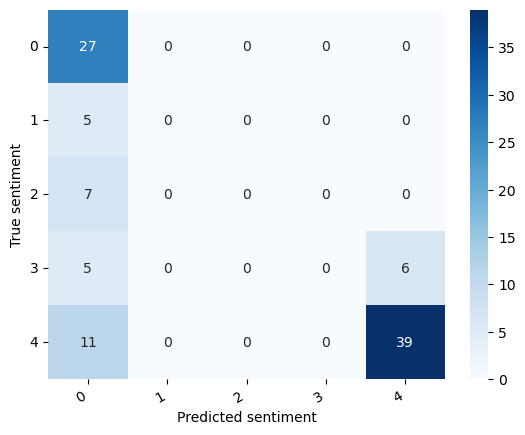

In [41]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
print(cm)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Test with example

In [42]:
def predict(text):
    encoding = tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=128,
      truncation=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')
    output = model(encoding['input_ids'],encoding['attention_mask'])
    _,prediction = torch.max(output, dim=1)
    return prediction.item() + 1

In [43]:
review_text = "I love completing my todos! Best app ever!!!"
print(f'Review text: {review_text}')
print(f'Sentiment  : {predict(review_text)}')

Review text: I love completing my todos! Best app ever!!!


c:\Users\Frederico\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Sentiment  : 5


In [44]:
review_text = "Terrible, i hated it"
print(f'Review text: {review_text}')
print(f'Sentiment  : {predict(review_text)}')

Review text: Terrible, i hated it
Sentiment  : 1
